The linear regression model discussed in Chapter 3 assumes the response variable $Y$ is quantititative. But in many situations, the response variable is instead *qualitative* (a.k.a. *categorical*). For example, eye color is qualitative, taking on values of blue, brown, or green. Predicting a qualitative response is known as *classification*. Predicting a qualitative response for an observation to a category or class can be referred to as *classifying* since it involves assigning the observation to a category, or class. The methods used for classification first predict the probability of each of the categories of a qualitative variable, which in a sense also behaves like linear regression.  

In this chapter we will discuss three of the most widely-used classifiers: *logistic regression*, *linear discriminant analysis*, and *K-nearest neighbors*.  

# An Overview of Classification
Some examples of classification include:  
1. A person arrives at the emergency room with a set of symptoms that could be attributed to one of three medical conditions. Which condition does the patient actually have?  
2. An online banking service must be able to determine whether or not a transaction is fraudulent on the basis of the user's IP address, past transaction history, and so forth.  
3. On the basis of DNA sequence data for a number of patients without a given disease, a biologist would like to figure out which DNA mutations are deleterious (disease-causing) and which are not.  

As in th regression setting, we have a set of training observations $(x_1, y_1), ..., (x_n, y_n)$ that we can use to build a classifier. We want our classifier to perform well not only on the training data, but unseen test data as well. We will be using the **Default** data set to predict whether an individual will default ($Y$) on their credit card payment on the basis of monthly credit card balance ($X_1$) and income ($X_2$). *Note: there is a very pronounced relationship between the predictors and the response, while in most real world applications, the relationship will not be nearly as strong*. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

In [2]:
default = pd.read_csv('../../data/Default.csv', index_col=0)
print('{}\n\n'.format(default.describe()))
print(default.describe(include=['O']))

            balance        income
count  10000.000000  10000.000000
mean     835.374886  33516.981876
std      483.714985  13336.639563
min        0.000000    771.967729
25%      481.731105  21340.462905
50%      823.636973  34552.644800
75%     1166.308387  43807.729275
max     2654.322576  73554.233500


       default student
count    10000   10000
unique       2       2
top         No      No
freq      9667    7056


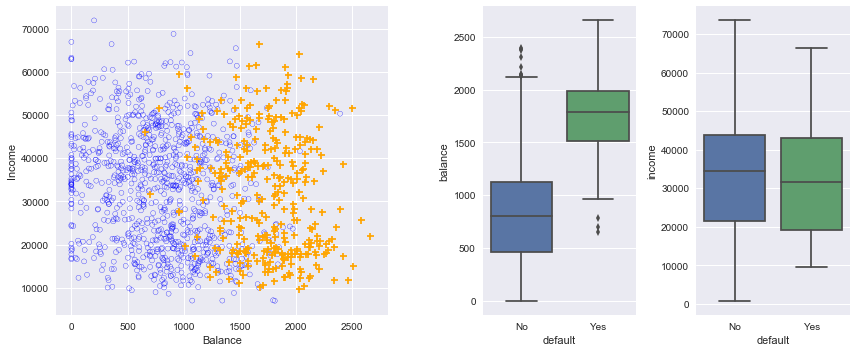

In [3]:
fig = plt.figure(figsize=(12, 5))

#this will create axes in which the left plot spans 2 columns 
#and the right two span only 1 column
ax1 = plt.subplot(121)
ax2 = plt.subplot(143)
ax3 = plt.subplot(144)

#take 1000 samples where the individual did not default
default_no_sample = default[default['default'] == 'No'].sample(n=1000)
ax1.scatter(default_no_sample['balance'].values,
            default_no_sample['income'].values,
            marker='o', edgecolors='blue', facecolors='None', s=25)
#include all samples where the individual did default
ax1.scatter(default[default['default'] == 'Yes']['balance'].values,
            default[default['default'] == 'Yes']['income'].values,
            marker='+', color='orange')
ax1.set(xlabel='Balance', ylabel='Income')

sns.boxplot(x=default['default'], y=default['balance'], ax=ax2)

sns.boxplot(x=default['default'], y=default['income'], ax=ax3)

fig.tight_layout()

# Why Not Linear Regression
Suppose we are trying to predict the medical condition of a patient in the emergency room on the basis of symptoms. If there are three possible diagnoses (stroke, drug overdose, or epileptic seizure), $Y$ would be coded as a quantitative response as follows:  

$$Y = \begin{cases}
1 & \text{if }\textbf{stroke}\\
2 & \text{if }\textbf{drug overdose}\\
3 & \text{if }\textbf{epileptic seizure}
\end{cases}$$  

Using this coding, least squares could be used to fit a linear regression to $Y$ on the basis of a set of predictors $X_1, ..., X_p$. Unfortunately, this coding implies an ordering of the outcomes, putting drug overdose in between stroke and epileptic seizuresm and insisting that the difference between stroke and drug overdose is the same as the difference between drug overdose and epileptic seizure. In practice however, there is no particular ordering to the response, so it can also be coded:  

$$Y = \begin{cases}
1 & \text{if }\textbf{epileptic seizure}\\
2 & \text{if }\textbf{stroke}\\
3 & \text{if }\textbf{drug overdose}
\end{cases}$$  

which would imply a completely different relationship among the three conditions in linear regression and thus a totally different prediction on test observations.  

If the response did take on a natural ordering, such as *mild*, *moderate*, and *severe*, and we felt that the gap between mild and moderate was similar to the gap between moderate and severe, then the 1, 2, 3 coding would be reasonable. Unfortunately, in general there is no natural way to convert a qualitative response variable with more than two levels into a quantitative response that is ready for linear regression modelling.  

The situation is better for a *binary* (two level) qualitative rsponse. For instance, perhaps there are only two possibilities for the patients medical condition: stroke or drug overdose. We could potentially use the *dummy variable* approach to code $Y$ as:  

$$Y = \begin{cases}
0 & \text{if }\textbf{stroke}\\
1 & \text{if }\textbf{drug overdose}
\end{cases}$$  

and simply predict drug overdose if $\widehat{Y} > 0.5$ and stroke otherwise. If we flipped the above coding, linear regression will produce the same results.  

Although in a binary response it can be shown that $X\widehat{\beta}$ is in fact an estimate of PR(drug overdose | $X$), some of our estimates might be outside the [0, 1] interval, making them hard to interpret as probabilities. Nevertheless, the predictions provide an ordering and can be interpreted as crude probability estimates.  

However, the dummy variable approach cannot be easily extended to accomodate qualitative responses with more than two levels. For these reasons, it's preferable to use a classification methot that is truly suited for qualitative response values.  

# Logistic Regression
Consider the default data set again, where the response falls into one of two categories, Yes or No. Rather than modeling this response directly, logistic regression models the *probability* that $Y$ belongs to a particular category.  For example the probability of default give balance can be written as  

$$\text{Pr}(default = \text{Yes} | balance)$$  

The values of $\text{Pr}(default = \text{Yes} | balance)$, which we abbreviate $p(balance)$, will range between 0 and 1. Then for any given value of balance, a prediction can be made for default. For example, one might predict $default = $Yes for any individual for whom $p(balance) > 0.5$. Alternatively, if a company wishes to be conservative in predicting individuals who are at risk, it may choose a lower threshold such as $p(balance) > 0.1$.  

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


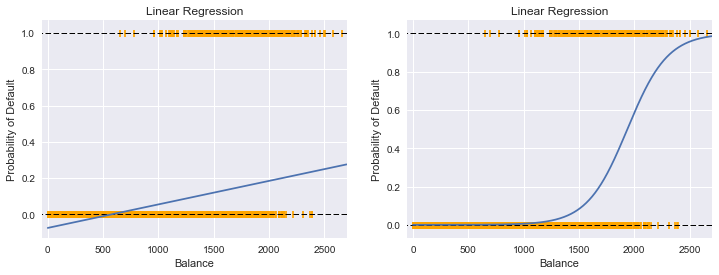

In [4]:
#figure 4.2

#create dummy variables for default and student
default2 = pd.get_dummies(default, drop_first=True)
#change the unites of income from $1 to $1000
default2['income'] = default2['income'] / 1000
#create linear regression and logit regression models
default_ols = smf.ols('default_Yes ~ balance', default2).fit()
default_logit = smf.logit('default_Yes ~ balance', default2).fit()
#create x variable for predictions
x = np.linspace(0, 2700, 1000)
#make predictions for each model
default_ols_pred = default_ols.predict(exog={'balance': x});
default_logit_pred = default_logit.predict(exog={'balance': x});
#create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#left panel
ax1.scatter(default2['balance'], default2['default_Yes'], marker='|', color='orange')
ax1.hlines(0, -100, 3000, linestyles='dashed', lw=1)
ax1.hlines(1, -100, 3000, linestyles='dashed', lw=1)
ax1.set(xlim=[min(x)-50, max(x)], xlabel='Balance', ylabel='Probability of Default',
        title='Linear Regression');
#this plots the linear regression line
ax1.plot(x, default_ols_pred);
#right panel
ax2.scatter(default2['balance'], default2['default_Yes'], marker='|', color='orange')
ax2.hlines(0, -100, 3000, linestyles='dashed', lw=1)
ax2.hlines(1, -100, 3000, linestyles='dashed', lw=1)
ax2.set(xlim=[min(x)-50, max(x)], xlabel='Balance', ylabel='Probability of Default',
        title='Linear Regression');
#this plots the logistic regression line
ax2.plot(x, default_logit_pred);

## The Logistic Model
In the left panel of the figure above we see the problem with using linear regression in a classification setting. Specifically, for values of balance close to zero, we predict a negative probabily of default while at very high values for balance, we will predict a probability greater than 1. These are not sensible predictions since the tru probability must fall between 0 and 1.  

To avoid this problem, we must model $p(X)$ using a function that gives outputs between 0 and 1 for all values of $X$. Many functions meet this description. In logistic regression we use the *logistic function*  

$$p(X) = \frac{e^{\beta_0 + \beta_1X}}{1 + e^{\beta_0 + \beta_1X}}$$  

To fit this model, we use a method called *maximum likelihood*. In the right panel of the above plot we have modeled the response with a logistic regression. Notice that for values of balance close to zero, we predict the probability of default as close to but never below zero. Likewise for high balances we predict a default probability close to but never greater than 1. So regardless of $X$ we will obtain a sensible prediction. The logistic regression is also better able to capture the range of probabilities than the linear regression model.  

After a bit of minipulation, we find that  

$$\frac{p(X)}{1 - p(X)} = e^{\beta_0 + \beta_1X}$$  

which is called the *odds*. Odds can take on any value between 0 and $\infty$, which indicate very low and very high probabilities respectively. For example, on average 1 in 5 people with an odds of $\frac{1}{4}$ will default (since $p(X) = 0.2$ implies an odds of $\frac{0.2}{1 - 0.2} = \frac{1}{4}$). Likewise an average 9 in 10 people with an odds of 9 will default (since $p(X) = 0.9$ implies an odds of $\frac{0.9}{1 - 0.9} = 9$). Odds are traditionally used in horse-racing, since they relate more naturally to the correct betting strategy.  

By taking the logorithm of both sides we get  

$$log\biggl(\frac{p(X)}{1 - p(X)}\biggr) = \beta_0 + \beta_1X$$  

The left-hand side is called the *log-odds* or *logit*. We see that the logistic regression model has a logit that is linear in $X$ space.  

Recall that in linear regression, the coefficient $\beta_1$ gives the average change in $Y$ due to a one-unit increase in $X$. In logistic regression, increasing $X$ by one unit changes the **log odds** by $\beta_1$ (or equivalently, it multiplies the odds by $e^{\beta_1}$). However, because the relationship between $p(X)$ and $X$ is not a straight line, $\beta_1$ does not correspond to the change in $p(X)$ associated with a one-unit increas in $X$. Instead, it can be interpreted that if $\beta_1$ is positive, then increasing $X$ will be associated with increasing $p(X)$ and vice versa.  

## Estimating the Regression Coefficients  
Although we could use (non-linear) least squares to fit the model and find the coefficients $\beta_0$ and $\beta_1$, the more general method of *maximum likelihood* is preferred, since it has better statistical properties. The basic intuition is: we seek estimates for $\beta_0$ and $\beta_1$ such that the predicted probability $\widehat{p}(x_i)$ of default for each individual corresponds as closely as possible to the individuals observed status. In other words, we try to find $\widehat{\beta}_0$ and $\widehat{\beta}_1$ such that plugging these into the model for $p(X)$ yields a number close to one for all individuals who defualted, and a number close to zero for all individuals who did not. This can be formalized using a mathematical equation called a *likelihood function*:  

$$\ell(\beta_0, \beta_1) = \prod_{i:y_i=1}p(x_i)\prod_{i^\prime:y_{i^\prime}=0}(1-p(x_{i^\prime}))$$  

The estimates $\widehat{\beta}_0$ and $\widehat{\beta}_1$ are chosen to *maximize* this likelihood function. Maximum likelihood is a very general approach that is used to fit many of the non-linear models. In regression, the least squares approach is a special case of maximum likelihood. 

In [5]:
#table 4.1
default_logit.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.6513,0.361,-29.491,0.000,-11.359,-9.943
balance,0.0055,0.000,24.952,0.000,0.005,0.006


The table above comes from fitting a logistic regression model on the default data set to predict the probability of default=Yes using balance. $\widehat{\beta}_1 =$ 0.0055, which indicates that an increase in balance is associated with an increase in the probability of default. A one-unit increase in balance will increase the log odds of default by 0.0055 units.  

Many aspects in the table are the same a as in linear regression. Accuracy of the coefficient estimates can be measured by computing the standard error. The z-statistic plays the same role as the t-statistic ($z = \frac{\widehat{\beta}_1}{SE(\widehat{\beta}_1}$) so a a large (absolute) value of the z-statistic indicates evidence against the null hypothesis $H_0: \beta_1 = 0$. This null hypothesis implies $p(X) = \frac{e^{\beta_0}}{1 + e^{\beta_0}}$ or that the probability of default does not depend on balance. Since the p-values are tiny in the table, we can reject the null hypothesis and conclude that there is a relationship between balance and the probability of default. The estimated intercept is typically not of interest; it's main purpose is to adjust the average fitted probabilities to the proportion of ones in the data.  

## Making Predictions
Once the coefficients have been estimated, it's simple to compute the probability of default for any given credit card balance. For example, using the coefficient estimates above, we predict that the default probability for an individual with a balance of $1,000 is  

$$\widehat{p}(X) = \frac{e^{\widehat{\beta}_0 + \widehat{\beta}_1X}}{1 + e^{\widehat{\beta}_0 + \widehat{\beta}_1X}} = \frac{e^{-10.6513 + 0.0055 \times 1,000}}{1 + e^{-10.6513 + 0.0055 \times 1,000}} = 0.00576$$  

which is less than 1%. In contrast, an individual with a balance of $2,000 will have a much higher probability of default at 58.6%.  

Qualitative predictors can also be used in logistic regression model using the dummy variable approach. 

In [6]:
default_logit = smf.logit('default_Yes ~ student_Yes', default2).fit()
default_logit.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-3.5041,0.071,-49.554,0.000,-3.643,-3.366
student_Yes,0.4049,0.115,3.520,0.000,0.179,0.630


The coefficient associated with the student dummy variable is positive and is statistically significant based on the p-valeus. These results indicate that students tend to have higher default probabilities than non-students:  

$$\widehat{Pr}(\text{default=Yes|student=Yes}) = \frac{e^{-3.5041 + 0.4049 \times 1}}{1 + e^{-3.5041 + 0.4049 \times 1}} = 0.0431$$  

$$\widehat{Pr}(\text{default=Yes|student=No}) = \frac{e^{-3.5041 + 0.4049 \times 0}}{1 + e^{-3.5041 + 0.4049 \times 0}} = 0.0292$$

## Multiple Logistic Regression
Now we consider the problem of predicting a binary response using multiple predictors. We can generalize the log odds as follows:  

$$log\biggl(\frac{p(X)}{1 - p(X)}\biggr) = \beta_0 + \beta_1X_1 + ... + \beta_pX_p$$  

where $X = (X_1, ..., X_p)$ are the $p$ predictors. This can be rewritten as  

$$p(X) = \frac{e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p}}{1 + e^{\beta_0 + \beta_1X_1 + ... + \beta_pX_p}}$$  

As before, we use maximum likelihood to estimate $\beta_0, \beta_1, ..., \beta_p$.  

In [7]:
default_logit = smf.logit('default_Yes ~ balance + income + student_Yes', default2).fit()
default_logit.summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-10.8690,0.492,-22.079,0.000,-11.834,-9.904
balance,0.0057,0.000,24.737,0.000,0.005,0.006
income,0.0030,0.008,0.370,0.712,-0.013,0.019
student_Yes,-0.6468,0.236,-2.738,0.006,-1.110,-0.184


The table above shows the coefficient estimates for a logistic regression model that uses balance, income (in $1,000), and student status to predict probability of default. The surprising result that can be seen is that, although the p-values associated with balance and student status indicate statistical significance of the predictors, the negative coefficient for student status indicates that students are less likely to default than non-students. In the single variable logistic regression for student status earlier, the coefficient for the dummy variable was positive. How can this be?

In [8]:
#create dataframes for students and non-students
default_student = default2[['default_Yes', 'student_Yes', 'balance']]
student_yes = default_student[default_student['student_Yes'] == 1]
student_no = default_student[default_student['student_Yes'] == 0]

#create the logistic regression for students and non-students
student_yes_logit = smf.logit('default_Yes ~ balance', student_yes).fit()
student_no_logit = smf.logit('default_Yes ~ balance', student_no).fit()

#create a range of balance for predicting
x_test = np.arange(default2['balance'].min(), default2['balance'].max())

#make predictions for students and non-students
y_pred_student_yes = student_yes_logit.predict(exog={'balance': x_test})
y_pred_student_no = student_no_logit.predict(exog={'balance': x_test})

#calculate the total default percentage for students and non-students
student_yes_default = student_yes['default_Yes'].sum() / len(student_yes)
student_no_default = student_no['default_Yes'].sum() / len(student_no)

Optimization terminated successfully.
         Current function value: 0.095687
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071433
         Iterations 10


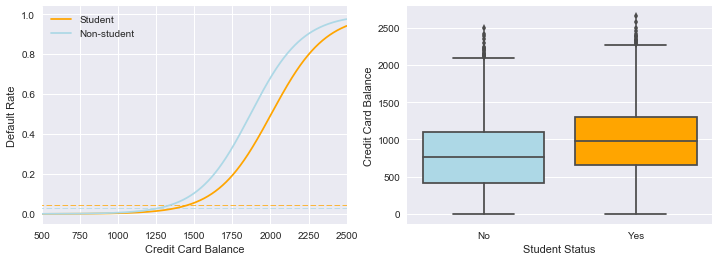

In [9]:
#figure 4.3

#create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#plot the default rate for students and non-students
y_pred_student_yes.plot(color='orange', ax=ax1)
y_pred_student_no.plot(color='lightblue', ax=ax1)

#left panel
#plot the total default rate for students and non-students
ax1.hlines(student_yes_default, 0, 2700, linestyles='--', 
           lw=0.75, color='orange')
ax1.hlines(student_no_default, 0, 2700, linestyles='--',
           lw=0.75, color='lightblue')
ax1.set(xlim=[500, 2500], xlabel='Credit Card Balance', 
        ylabel='Default Rate')
ax1.legend(['Student', 'Non-student'], loc=0)

#right panel
#make the boxplot
bp = sns.boxplot(x=default2['student_Yes'], y=default2['balance'], ax=ax2)
#change the facecolors to match the left panel
bp.artists[1].set_facecolor('orange')
bp.artists[0].set_facecolor('lightblue')
#change the xtick labels (from 0 and 1)
ax2.set(xticklabels=['No', 'Yes'], xlabel='Student Status', 
        ylabel='Credit Card Balance');

The left panel in the figure above shows a graphical representation of this paradox. The negative coefficient for student status in the multiple logistic regression indicates that *for a fixed value of* balance *and* income, a student is less likely to default than a non student. However the horizontal lines near the base of the plot show the opposite; students have a higher default rate than non-students. This can be explained with the right panel where the correlation between student status and balance is evident.  

Students tend to hold higher levels of debt, which is in turn associated with higher probability of default. This would be important information for a credit card company when trying to determine to whom they should offer credit. A student is riskier than a non-student *if no information about the student's credit card balance is available*. However, that student is less risky than a non-student *with the same credit card balance*!  

As in linear regression, the results obtained using a single predictor may be quite different from those obtained using multiple predictors, especially when there is correlation among the predictors. In general this is known as *confounding*.  

## Logistic Regression for >2 Response Classes
Consider the patients discussed earlier whose symptoms could be classified in three ways: stroke, drug overdose, and epileptic seizures. In this setting we wish to model both $Pr(Y = \text{stroke} | X)$ and $Pr(Y = \text{drug overdose} | X)$ with the remaining probability for $Pr(Y = \text{epileptic seizure} | X) = 1 - Pr(Y = \text{stroke} | X) - Pr(Y = \text{drug overdose} | X)$. The two-class logistic regression models discussed have multiple-class extension, but they aren't used too often. Enter *discriminant analysis*; a popular method for multiple-class classification.

# Linear Discriminant Analysis
Logistic regression involves directly modeling $Pr(Y = k|X = x)$ using the logistic function for the two-case response. Now we consider a less direct approach to estimate the probabilities. In this approach, we model the distribution of the predictors $X$ separately in each of the response classes (i.e. given $Y$), and then use Bayes' theorem to flip these around into estimates for $Pr(Y=k|X=x)$. When distributions are assumed normal, this is very similar to logistic regression.  

Why do we need another method when we have logistic regression?  
* When the classes are well-separated, the parameter estimates for logistic regression are suprisingly unstable. Linear discriminant analysis does not suffer from this problem.  
* If $n$ is small and the distribution of the predictors $X$ is approximately normal in each of the classes, the linear discriminant model is again more stable than the logistic regression model.  
* Linear disrcriminant analysis is popular when we have more than two response classes.  

## Using Bayes' Theorem for Classification
Suppose we wish to classify an observation into on of $K$ classes, where $K \ge 2$. Let $\pi_k$ represent the overall or *prior* probability that a randomly chosen observation comes from the $k$th class; this is the probability that a given observation is associated with the $k$th category of the response variable $Y$. Let $f(k) \equiv Pr(X=x|Y=k)$ denote the *density function* of $X$ for an observation that comes from the $k$th class. $f_k(x)$ will be relatively large if there is a high probability that an observation in the $k$th class has $X \approx x$ and $f_k(x)$ will be small if it is very unlikely that an observation in the $k$th class has $X \approx x$. Then *Bayes' theorem* states that  

$$Pr(Y=k|X=x) = \frac{\pi_kf_k(x)}{\sum_{l=1}^K\pi_lf_l(x)}$$  

Keeping with earlier notation, we'll use $p_k(X) = Pr(Y = k | X)$. This suggests that instead of directly computing $p_k(X)$ as in logistic regression, we can simply plug in estimates of $\pi_k$ and $f_k(X)$ into the equation above. Estimating $\pi_k$ is easy if we have a random sample of $Y$s from the population: we simple compute the fraction of the training observations that belong to the $k$th class. Estimating $f_k(X)$ is a bit more challenging (unless we assume some simple forms for the densities). We refer to $p_k(x)$ as the *posterior* probability that an observation $X = x$ belongs in the $k$th class. That is, the probability that the observation belongs to the $k$th class, *given* the predictor value for that observation.  

## Linear Discriminant Analysis for $p = 1$
Assuming we only have one predictor ($p$ = 1). We want to obtain an estimate for $f_k(x)$ that can be plugged in to the equation above in order to estimate $p_k(x)$. We will then classify an observation to the class for which $p_k(x)$ is greatest. We must first make some assumption about the form of $f_k(x)$.  

Suppose we assume that $f_k(x)$ is *normal* or *Gaussian*. In one-dimenstion, the normal density takes the form  

$$f_k(x) = \frac{1}{\sqrt{2\pi}\sigma_k}\text{exp}\bigl(-\frac{1}{2\sigma_k^2}(x-\mu_k)^2\bigr)$$  

where $\mu_k$ and $\sigma_k^2$ are the mean and variance parameters for the $k$th class. For now, let's assume a shared variance term $\sigma^2$ across all $K$ classes (i.e. $\sigma_1^2 = \sigma_2^2 = ... = \sigma_K^2$). Plugging this in to the previous equation we get  

$$p_k(x) = \frac{\pi_k\frac{1}{\sqrt{2\pi}\sigma}\text{exp}\bigl(-\frac{1}{2\sigma^2}(x - \mu_k)^2\bigr)}{\sum_{l=1}^K\pi_l\frac{1}{\sqrt{2\pi}\sigma}\text{exp}\bigl(-\frac{1}{x\sigma_2}(x - \mu_l)^2\bigr)}$$  

The Bayes classifier involves assigning an observation $X = x$ to the class for which this equation is the largest. Taking the log and rearranging the terms it can be shown that this is equivalent to assigning the observation to the class for which  

$$\delta_k(x) = x \cdot\frac{\mu_k}{\sigma^2} - \frac{\mu_k^2}{2\sigma^2} + \text{log}(\pi_k)$$  

is largest. For instance, if $K = 2$ and $\pi_1 = \pi_2$, then the Bayes classifier assigns an observation to class 1 if $2x(\mu_1 - \mu_2) > \mu_1^2 - \mu_2^2$ and to class 2 otherwise. In this case the Bayes decision boundary corresponds to the point where  

$$x = \frac{\mu_1^2 - \mu_2^2}{2(\mu_1 - \mu_2)} = \frac{\mu_1 + \mu_2}{2}$$

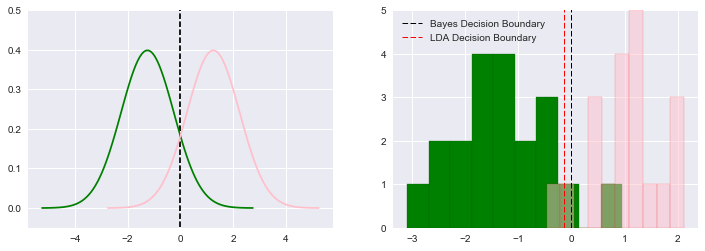

In [10]:
#figure 4.4
from scipy.stats import norm

mu_1 = -1.25
mu_2 = 1.25
variance = 1
sigma = np.sqrt(variance)
x_1 = np.linspace(mu_1 - 4*sigma, mu_1 + 4*sigma, 100)
x_2 = np.linspace(mu_2 - 4*sigma, mu_2 + 4*sigma, 100)
y_1 = norm.pdf(x_1, loc=mu_1, scale=1)
y_2 = norm.pdf(x_2, loc=mu_2, scale=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(x_1, y_1, color='green')
ax1.plot(x_2, y_2, color='pink')
ax1.vlines(0, -1, .5, linestyles='--', color='k')
ax1.set(ylim=[-.05,0.5])

x_1_sample = np.random.normal(loc=mu_1, scale=sigma, size=20)
x_2_sample = np.random.normal(loc=mu_2, scale=sigma, size=20)
x = (x_1_sample.mean() + x_2_sample.mean())/2
ax2.hist(x_1_sample, color='green', edgecolor='darkgreen')
ax2.hist(x_2_sample, color='pink', alpha=0.5, edgecolor='red')
ax2.vlines(0, 0, 6, linestyles='--', color='k', lw=1)
ax2.vlines(x, 0, 6, linestyles='--', color='r', lw=1)
ax2.set(ylim=[0,5]);
ax2.legend(['Bayes Decision Boundary', 'LDA Decision Boundary'])

Assuming that an observation is equally likely to come from either class ($\pi_1 = \pi_2 = 0.5$), we see that the Bayes classifier assigns the observation to class 1 if $x<0$ and class 2 otherwise. *Note that in this case we can compute the Bayes classifier because we know that $X$ is drawn from a Gaussian distribution within each class, and we know all the parameters involved. In the real world, we are usually not able to calculate the Bayes classifier.*  

Even if we are quite sure of our assumption that $X$ is drawn from a Gaussian distribution within each class, we still have to estimate the parameters $\mu_1, ..., mu_K$, $\pi_1, ..., pi_K$, and $\sigma^2$. The *linear discriminant analysis* (LDA) method approximates the Bayes classifier by plugging estimates for $\pi_k$, $\mu_k$, and $\sigma^2$ into the equation for $\delta(x)$ from before. In particular, the following are the estimates used:  

$$\widehat{\mu}_k = \frac{1}{n_k}\sum_{i:y_i=k}x_i$$  

$$\widehat{\sigma}^2 = \frac{1}{n-K}\sum_{k=1}^K\sum_{i:y_i=k}(x_i - \widehat{\mu}_k)^2$$  

where $n$ is the total number of traning observations, and $n_k$ is the number of training observations in the $k$th class. The estimate for $\widehat{\mu}_k$ is simply the average of all training observations from the $k$th class, while $\widehat{\sigma}^2$ can be seen as a weighted average of the sample variances for each of the $K$ classes. Sometimes we have knowledge of the class membership probabilities $\pi_1, ..., \pi_K$, which can be used directly. In the absence of any additional information, LDA estimates $\pi_k$ with  

$$\widehat{\pi}_k = \frac{n_k}{n}$$  

The LDA classifier plugs these three estimates into the equation for $\delta_k(x)$ and assigns an observation $X = x$ to the class for which  

$$\widehat{\delta}_k(x) = x\cdot\frac{\widehat{\mu}_k}{\widehat{\sigma}^2} - \frac{\widehat{\mu}_k^2}{2\widehat{\sigma}^2} + \text{log}(\widehat{\pi}_k)$$  

is largest. The word *linear* in the classifiers name is because the *discriminant functions* $\widehat{\delta}_k(x)$ are linear functions of $x$.  

In [11]:
bayes_error = []
lda_error = []
#this is already calculated above
#x = (x_1_sample.mean() + x_2_sample.mean())/2
for i in range(10000):
    x_1_sample = np.random.normal(loc=mu_1, scale=sigma, size=20)
    x_2_sample = np.random.normal(loc=mu_2, scale=sigma, size=20)
    bayes_error.append((x_1_sample > 0).sum()/20)
    bayes_error.append((x_2_sample < 0).sum()/20)
    lda_error.append((x_1_sample > x).sum()/20)
    lda_error.append((x_2_sample < x).sum()/20)
print('Bayes Error Rate: {:.2f}%'.format(np.mean(bayes_error)*100))
print('LDA Error Rate: {:.2f}%'.format(np.mean(lda_error)*100))

Bayes Error Rate: 10.56%
LDA Error Rate: 10.76%


## Linear Discriminant Analysis for $p>1$
To extend the LDA classifier to the case of multiple predictors, we will assume that $X = (X_1, X_2, ..., X_p)$ is drawn from a *multivariate Gaussian* (or multivariate normal) distribution, with a class-specific mean vector and a common covariance matrix.  

The multivariate Guassian distribution assumes that each individual predictor follows a one-dimensional normal distribution with some correlation between each pair of predictors. If $\text{Var}(X_1) = \text{Var}(X_2)$ and $\text{Cor}(X_1, X_2) = 0$; this surface has a charactaristic *bell shape*. The bell shape will be distorted if the predictors are correlated or have unequal variance. To indicate that a $p$-dimensional random variable $X$ has a multivariate Gaussian distribution, we write $X ~ N(\mu, \Sigma)$ where $\mathbb{E}(X) = \mu$ is the mean of $X$, and $\text{Cov}(X) = \Sigma$ is the $p\times p$ covariance matrix of $X$. Formally, the multivariate Gaussian density is defined as  

$$f(x) = \frac{1}{(2\pi)^{p/2}\bigl|\Sigma\bigr|^{1/2}}exp\bigl(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x - \mu)\bigr)$$  

In the case of $p>1$ predictors, the LDA classifier assumes that the observations in the $k$th class are drawn from a multivariate Gaussian distribution $N(\mu_k, \Sigma)$, where $\mu_k$ is a class-specific mean vector, and $\Sigma$ is a covariance matrix that is common to all $K$ classes. Plugging the density function for the $k$th class, $f_k(X=x)$, into the Bayes theorem formula mentioned earlier, and performing a little algebra, reveals that the Bayes classifier assigns an observation $X=x$ to the class for which  

$$\delta_k(x) = x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k + \text{log}\pi_k$$  

is largest. This is the vector/matrix form of the discriminant functions $\delta_k$.

[<matplotlib.text.Text at 0x1c778780>, <matplotlib.text.Text at 0x1c765ef0>]

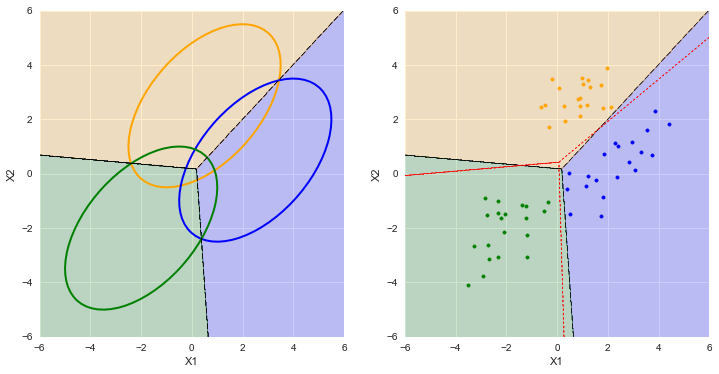

In [12]:
#figure 4.6

from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#define the mu_k's
c1_means = [.5, 2.5]
c2_means = [2.5, .5]
c3_means = [-2, -2]
#define the covariance matrix
cov = [[1, 0.5], [0.5, 1]]
#create the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#calculate the eigen vectors (for width and height of ellipse)
vals, vecs = np.linalg.eig(cov)
order = vals.argsort()[::-1]
vals, vecs = vals[order], vecs[:, order]
#calculate the angle for the ellipse
theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
#get the width and the height (3 standard deviations is about 95% confidence)
width, height = 2 * 3 *np.sqrt(vals)
#add each ellipse to the plot
for cl, col in zip([c1_means, c2_means, c3_means],['orange', 'blue', 'green']):
    ellip = Ellipse(xy=cl, width=width, height=height, angle=theta, edgecolor=col, 
                    facecolor='none', lw=2)
    ax1.add_artist(ellip)
#change the x-limits
ax1.set(xlim=[-6, 6], ylim=[-6, 6]);
#create x1's and x2's for three different classes
c1_x1, c1_x2 = np.random.multivariate_normal(c1_means, cov, 100000).T
c2_x1, c2_x2 = np.random.multivariate_normal(c2_means, cov, 100000).T
c3_x1, c3_x2 = np.random.multivariate_normal(c3_means, cov, 100000).T
#this section will create the dataframe for modeling
x1 = np.concatenate((c1_x1, c2_x1, c3_x1))
x2 = np.concatenate((c1_x2, c2_x2, c3_x2))
#assign each point to a class (0, 1, 2)
class0 = np.zeros_like(c1_x1)
class1 = np.ones_like(c1_x1)
class2 = np.ones_like(c1_x1)*2
classes = np.concatenate((class0, class1, class2))
#make the dataframe
df = pd.DataFrame({'x1': x1, 'x2': x2, 'class': classes})
#cast the class as an integer
df['class'] = df['class'].astype('int')
#create np arrays for the predictors and response
X = df[['x1', 'x2']].values
y = df['class'].values
#create an instance of the LDA model
lda=LDA()
#fit the model to the data
lda.fit(X, y)
#create a mesh grid for plotting
X1, X2 = np.meshgrid(np.linspace(-6, 6, 1000), np.linspace(-6, 6, 1000))
#now add contours based on predictions for each point in the grid
ax1.contourf(X1, X2, lda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
                 alpha=0.2, cmap=ListedColormap(('orange', 'blue', 'green')))
ax1.contour(X1, X2, lda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
            linestyles='dashed', colors='black', linewidths=0.4)
ax2.contourf(X1, X2, lda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
                 alpha=0.2, cmap=ListedColormap(('orange', 'blue', 'green')))
ax2.contour(X1, X2, lda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
            linestyles='dashed', colors='black', linewidths=0.3)
#now create the samples plot
c1_x1_sample, c1_x2_sample = np.random.multivariate_normal(c1_means, cov, 20).T
c2_x1_sample, c2_x2_sample = np.random.multivariate_normal(c2_means, cov, 20).T
c3_x1_sample, c3_x2_sample = np.random.multivariate_normal(c3_means, cov, 20).T
class_0_sample = np.zeros_like(c1_x1_sample)
class_1_sample = np.ones_like(c1_x1_sample)
class_2_sample = class_1_sample * 2
x1_sample = np.concatenate((c1_x1_sample, c2_x1_sample, c3_x1_sample))
x2_sample = np.concatenate((c1_x2_sample, c2_x2_sample, c3_x2_sample))
classes_sample = np.concatenate((class_0_sample, class_1_sample, class_2_sample))
df_sample = pd.DataFrame({'x1': x1_sample, 'x2': x2_sample, 'class': classes_sample})
df['class'] = df['class'].astype('int')
X_sample = df_sample[['x1', 'x2']].values
y_sample = df_sample['class'].values
lda_sample = LDA()
lda_sample.fit(X_sample, y_sample)
ax2.scatter(c1_x1_sample, c1_x2_sample, marker='.', color='orange')
ax2.scatter(c2_x1_sample, c2_x2_sample, marker='.', color='blue')
ax2.scatter(c3_x1_sample, c3_x2_sample, marker='.', color='green')
ax2.contour(X1, X2, lda_sample.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
            colors='red', linestyles='dotted', linewidths=0.5)

ax1.set(xlabel='X1', ylabel='X2')
ax2.set(xlabel='X1', ylabel='X2')

In the left panel of the plot above, three equally sized Gaussian classes are show with class specific mean vectors and a common covariance matrix. The three elipses represent regions that contain 95%of the probability for each of the three classes. The dashed lines are the Bayes decision boundaries. In other words they represent the set of values $x$ for which $\delta_k(x) = \delta_l(x)$; i.e.  

$$x^T\Sigma^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma^{-1}\mu_k = x^T\Sigma^{-1}\mu_l - \frac{1}{2}\mu_l^T\Sigma^{-1}\mu_l$$

for $k \neq l$. There are three lines representing the Bayes decision boundaries because there are three *pairs of classes*. In the right panel, 20 observations are drawn from each of the three classes and the resulting LDA decision boundaries are shown with the red dotted lines.  

We can perform LDA on the default data set in order to predict whether or not an individual will default on the basis of credit card balance and student status. 

In [13]:
#Table 4.4

from sklearn.metrics import confusion_matrix

default = pd.read_csv('../../data/Default.csv', index_col=0)
default = pd.get_dummies(default, drop_first=True)

X = default[['balance', 'student_Yes']].values
y = default['default_Yes'].values

lda = LDA()
lda.fit(X, y)
y_pred = lda.predict(X)
cm = confusion_matrix(y, y_pred)
cm.T

array([[9644,  252],
       [  23,   81]])

The LDA model fit to the 10,000 training samples results in a training error of 2.75% ((252 + 23) / 1000). While this sounds like a low error rate, two caveats must be noted  
1. Training error rates will usually be lower than test error rates, which are the real quantity of interest. The higher the ratio of parameters $p$ to number of samples $n$, the more we expect *overfitting* to play a role. For the default data set we don't expect this to be much of an issue since $p=2$ and $n=10,000$.  
2. Since only 3.33% of the individuals in the training sample defaulted, a simple but useless classifier that always predicts each individual will not default, regardless of his or her credit card balance and student status, will result in an error rate of 3.33%. In other words, the trivial *null* classifier will achieve an error rate that is only a bit higher than the LDA training set error rate.  

In practice, a binary classifier can make two types of errors: it can incorrectly assign an individual who defaults to the *no default* category, or it can incorrectly assign an individual who does not default to the *default* category. It is often of interest to determine which of these two types of errors are being made. A *confusion matrix* is a convenient way to display this information. Of the 333 individuals that defaulted, 252 (or 75.7%) were missed by the LDA. So while the overall error rate is low, the error rate among individuals who defaulted is very high.

Class-specific performance is also important in medicine and biology, where the terms *sensitivity* and *specificity* charactarize the performance of a classifier or screening test. In this case the sensitivity is the percentage of true defaulters that are identified, a low 24.3% in this case (81 / (81 + 252)). The specificity is the percentage of non-defaulters that are correctly identified, here (1 - 23/9667) * 100 = 99.8%.  

Why does the LDA do such a poor job of classifying the customers who default (e.g. low sensitivity)? LDA is trying to approximate the Bayes classifier which has the lowest *total* error rate out of all classifiers. That is, the Bayes classifier will yield the smallest possible total number of misclassified observations, irrespective of which class the errors come from.  

The Bayes classifier works by assigning an observation to the class for which the posterior probability $p_k(X)$ is greatest. In the two-class case, this amounts to assigning an observation to the *default* class if  

$$Pr(\text{default = Yes}|X=x) > 0.5$$  

Thus, the Bayes classifier, and by extension LDA, uses a threshold of 50% for the posterior probability of default in order to assign an observation to the *default* class. However, if we are concerned about incorrectly predicting the default status for individuals who default, we can consider lowering this threshold (to say 20%). 

In [14]:
#Table 4.5

y_prob = lda.predict_proba(X)
y_prob[y_prob >= 0.2] = 1
y_prob[y_prob < 0.2] = 0
cm = confusion_matrix(y, y_prob[:, 1])
cm.T

array([[9432,  138],
       [ 235,  195]])

Now the LDA predicts that 430 individuals will default. Of the 333 who did default, LDA correctly predicts all but 138, or 41.4%. This is a vast improvement over the error rate of 75.7% that resulted from the threshold of 50%. This comes at a cost though, with 235 individuals who do not default being incorrectly classified. As a result the overall error rate has increased slightly to 3.73%. But the credit card company may consider this slight increase in total error rate to be a small price to pay for more accurate identification of individuals who do indeed default.  

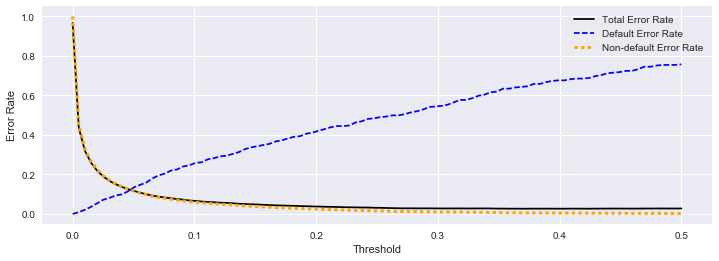

In [15]:
#figure 4.7

thresh = np.linspace(0, 0.5, 100)
total_error_rate = []
default_incorrect = []
non_default_incorrect = []
for t in thresh:
    y_prob = lda.predict_proba(X)
    y_prob[y_prob >= t] = 1
    y_prob[y_prob < t] = 0
    cm = confusion_matrix(y, y_prob[:, 1])
    total_error_rate.append((cm[0, 1] + cm[1, 0]) / cm.sum())
    default_incorrect.append(cm[1, 0] / cm[1, :].sum())
    non_default_incorrect.append(cm[0, 1] / cm[0, :].sum())
    
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(thresh, total_error_rate, color='k')
ax.plot(thresh, default_incorrect, color='b', linestyle='--')
ax.plot(thresh, non_default_incorrect, color='orange', linestyle='dotted', lw=3)
ax.set(xlabel='Threshold', ylabel='Error Rate')

ax.legend(['Total Error Rate', 'Default Error Rate', 'Non-default Error Rate'])

The figure above shows three different error rates as a function of the threshold value. A threshold value of 0.5 minimizes the overall error rate, which is not surprising considering the Bayes classifier uses this threshold and has the lowest overall error rate. As threshold is reduced, the error rate among individuals who default decreases steadily, but the error rate among the individuals who do not default increases. How can we decide which threshold is best? *Domain knowledge* must be used, such as detailed information about the costs associated with default  

AUC: 0.9442


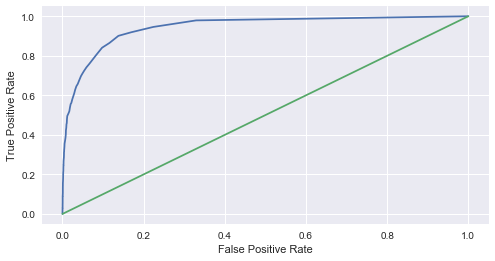

In [16]:
#figure 4.8

from sklearn.metrics import roc_curve, auc

y_prob = lda.predict_proba(X)
thresh = np.linspace(0, 1, 100)
tpr = []
fpr = []
for t in thresh:
    yp = y_prob.copy()
    yp[yp >= t] = 1
    yp[yp < t] = 0
    cm = confusion_matrix(y, yp[:, 1])
    tpr.append(cm[1, 1] / cm[1, :].sum())
    fpr.append(1 - cm[0, 0] / cm[0, :].sum())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1])
ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')

print('AUC: {:.4f}'.format(auc(fpr, tpr)))

The *receiver operating charactaristic* (ROC) curve is a popular graphic for simultaneously displaying the two types of errors for all possible thresholds. The overall performance of a classifier, summarized over all possible thresholds, is given by the *area under the (ROC) curve* (AUC). An ideal ROC curve will hug the top left corner, so the larger the AUC the better the classifier. For this LDA model, the AUC is 0.94, which is close to the maximum of one so would be considered very good. A classifier that performs no better than chance (orange line) will have an AUC of 0.5. ROC curves are useful for comparing different classifiers since they take into account all thresholds.  

As we've seen, varying the classifier threshold changes the true positive and false positive rates. These are called the *sensitivity* and one minum *specificity*. The table below shows the possible results when applying a classifier (or diagnostic test) to a population.

<table align="left">
  <tr>
    <td colspan="2"></td>
    <td colspan="2" style="text-align:center">*Predicted class*</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"></td>
    <td style="text-align:center">- or Null</td>
    <td style="text-align:center">+ or Non-null</td>
    <td style="text-align:center">Total</td>
  </tr>
  <tr>
    <td rowspan="2" style="text-align:center">*True class*</td>
    <td style="text-align:center">- or Null</td>
    <td style="text-align:center">True Neg. (TN)</td>
    <td style="text-align:center">False Pos. (FP)</td>
    <td style="text-align:center">N</td>
  </tr>
  <tr>
    <td style="text-align:center">+ or Non-null</td>
    <td style="text-align:center">False Neg. (FN)</td>
    <td style="text-align:center">True Pos. (TP)</td>
    <td style="text-align:center">P</td>
  </tr>
  <tr>
    <td></td>
    <td style="text-align:center">Total</td>
    <td style="text-align:center">N\*</td>
    <td style="text-align:center">P\*</td>
    <td></td>
</table>

The table below lists many of the popular performance measures that are used in this context.

<table align="left">
  <tr>
    <td>Name</td>
    <td>Definition</td>
    <td>Synonyms</td>
  </tr>
  <tr>
    <td>False Positive Rate</td>
    <td>FP/N</td>
    <td>Type I Error, 1-Specificity, fall-out</td>
  </tr>
  <tr>
    <td>True Positive Rate</td>
    <td>TP/P</td>
    <td>1-Type II Error, power, sensitivity, recall, hit rate</td>
  </tr>
  <tr>
    <td>True Negative Rate</td>
    <td>TN/N</td>
    <td>Specificity</td>
  </tr>
  <tr>
    <td>False Negative Rate</td>
    <td>FN/P</td>
    <td></td>
  </tr>
  <tr>
    <td>Positive Predictive value</td>
    <td>TP/P\*</td>
    <td>Precision, 1-false discovery proportion</td>
  </tr>
  <tr>
    <td>Negative Predictive Value</td>
    <td>TN/N\*</td>
    <td></td>
  </tr>
  <tr>
    <td>Accuracy</td>
    <td>(TP+TN)/(TP+FP+FN+TN)</td>
    <td></td>
  </tr>

## Quadratic Discriminant Analysis
Like LDA, *Quadratic discriminant analysis* (QDA) assumes that observations within each class are drawn from a multivariate Gaussian distribution with a class specific mean vector. However, QDA assumes that each class has its own covariance matrix. That is, it assumes that an observation from the $k$th class is of the form $X ~ N(\mu_k, \Sigma_k)$ where $\Sigma_k$ is a covariance matrix for the $k$th class. Under this assumption, the Bayes classifier assigns an observation $X = x$ to the class for which  

$$\delta_k = -\frac{1}{2}(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k) - \frac{1}{2}\text{log}|\Sigma_k| + \text{log}\pi_k$$  

$$= -\frac{1}{2}x^T\Sigma_k^{-1}x + x^T\Sigma_k^{-1}\mu_k - \frac{1}{2}\mu_k^T\Sigma_k^{-1}\mu_k - \frac{1}{2}\text{log}|\Sigma_k| + \text{log}\pi_k$$  

is largest. As described in the name, the quantity $x$ appears as a *quadratic* function.  

When would one prefer QDA over LDA? The answer lies in the bias-variance trade-ff. When there are $p$ predictors, estimating a single covariance matrix requires estimating $p(p+1)/2$ parameters. Since QDA estimates a separate covariance matrix for each class, there are a total of $Kp(p+1)/2$ parameters. When there are many predictors, this can be too compute intensive. By assuming a shared covariance matrix, the LDA model becomes linear in $x$, which means there are only $Kp$ linear coefficients to estimate. The LDA is much less flexible than QDA, and has subsequently lower variance which can potentially lead to improved prediction performance. But, if the LDA's assumption that the $K$ classes share a common covariance matrix are badly off, then LDA can suffer from high bias. LDA tends to be better than QDA if there are relatively few training observations. QDA is recommended if the training set is very large, so that the variance of the classifier is not a major concern or if the assumption of a common covariance matrix for the $K$ classes is clearly untenable.  

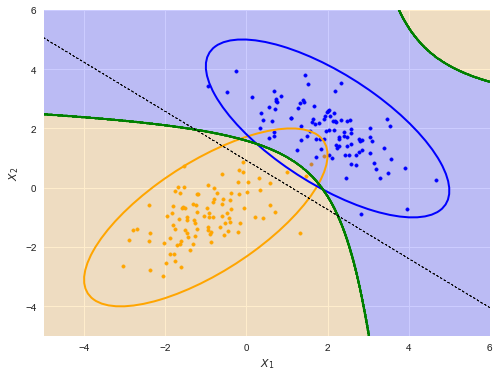

In [17]:
#Figure 4.9 right panel

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

c1_means = [-1, -1]
cov1 = [[1, 0.7], [0.7, 1]]
c1_x1, c1_x2 = np.random.multivariate_normal(c1_means, cov1, 100).T
c1_class = np.zeros_like(c1_x1)
c2_means = [2, 2]
cov2 = [[1, -.7], [-.7, 1]]
c2_x1, c2_x2 = np.random.multivariate_normal(c2_means, cov2, 100).T
c2_class = np.ones_like(c2_x1)

df = pd.DataFrame({'x1': np.concatenate((c1_x1, c2_x1)),
                   'x2': np.concatenate((c1_x2, c2_x2)),
                   'class': np.concatenate((c1_class, c2_class))})
df['class'] = df['class'].astype('int')
X = df[['x1', 'x2']].values
y = df['class'].values

fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))

for cov, col, cmean in zip([cov1, cov2], ['orange', 'blue'], [c1_means, c2_means]):
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * 3 * np.sqrt(vals)
    ellip = Ellipse(xy=cmean, width=width, height=height, angle=theta, edgecolor=col,
                   facecolor='none', lw=2)
    ax1.add_artist(ellip)
ax1.scatter(c1_x1, c1_x2, marker='.', color='orange')
ax1.scatter(c2_x1, c2_x2, marker='.', color='blue')
ax1.set(xlim=[-5, 6], ylim=[-5, 6])

lda = LDA()
qda = QDA()

lda.fit(X, y)
qda.fit(X, y)

X1, X2 = np.meshgrid(np.linspace(-6, 6, 1000), np.linspace(-6, 6, 1000))

ax1.contourf(X1, X2, qda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
             alpha=0.2, cmap=ListedColormap(('orange', 'blue')))
ax1.contour(X1, X2, qda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), 
            colors='green', liewidths=2)
ax1.contour(X1, X2, lda.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
            colors='black', linestyles='dotted', linewidths=0.5);
ax1.set(xlabel=r'$X_1$', ylabel=r'$X_2$');

The figure above shows a situation in which the covariance matrix are clearly unequal for the two classes. Because of this the Bayes decision boundary (not shown) is quadratic, and the QDA more accurately approximates this boundary than does LDA.

# A Comparison of Classification Methods
When the true decision boundary is linear, then the LDA and logistic regression approaches tend to perform well. When the boundaries are moderately non-linear, QDA may give better results. Finally, for much more complicated decision boundaries, a non-parametric approach such as KNN can be superior. But the level of smoothness for a non-parametric approach must be chosen carefully.